# E301 Optic 1 Plasma Design

In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from ionization import ionization
from lens import profile
from lens import design
import matplotlib.pyplot as plt
import beam.calc.electron as ecalc
from scipy.integrate import simps
from scipy.constants import physical_constants as consts
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from ionization import adk

sys.path.insert(0, "../../khuntstone/Field_Ionization")
sys.path.insert(0, "../../khuntstone")
import eBeam_v02 as eb
import plotty as pl

plt.style.use('notes')
%load_ext autoreload
%autoreload 2

path = '/mnt/md0/Data/rariniello/E301/E301_1_H2/'
lam = 0.796
eps0 = consts['electric constant'][0]

First design attempt to create a plasma source that has the proper shape to match a beam into a plasma accelerator and accelerate the particle. The plasma source will have Gaussian ramps for a first pass to figure out the rest of the important physics.

Below, I list the drive beam and witness beam parameters from Glen White's E-300 collaboration meeting presentation on July 15, 2019. Parameters are measured at the Sector 20 IP (labelled PENT in the presentation) which is 2.5m downstream of the center of Q0FF, the last final focus quad.

In [2]:
# Drive beam parameters
drive = {}
drive_final  = {}
drive['alpha_x'] = 1.7
drive['alpha_y'] = 2.2
drive['beta_x'] = 33e-2 #33 cm
drive['beta_y'] = 33e-2 #33 cm
drive['eps_nx'] = 35e-6
drive['eps_ny'] = 115e-6
drive['charge'] = 1.498 #nC
drive['energy'] = 10.078 #GeV
drive['delta'] = 0.00837
drive['sigma_z'] = 31.44e-6 #31.4um
drive['gamma_x'] = (1+drive['alpha_x']**2)/drive['beta_x']
drive['gamma_y'] = (1+drive['alpha_y']**2)/drive['beta_y']

# Witness beam parameters
witness = {}
witness_final = {}
witness['alpha_x'] = 0.1
witness['alpha_y'] = 0.7
witness['beta_x'] = 5.0e-2 #5 cm
witness['beta_y'] = 7.0e-2 #7 cm
witness['eps_nx'] = 3.7e-6
witness['eps_ny'] = 4.1e-6
witness['charge'] = 0.499 #nC
witness['energy'] = 9.921 #GeV
witness['delta'] = 0.00264
witness['sigma_z'] = 3.25e-6 #3.25um
witness['gamma_x'] = (1+witness['alpha_x']**2)/witness['beta_x']
witness['gamma_y'] = (1+witness['alpha_y']**2)/witness['beta_y']

Plasma length is set by the drive beam energy. The length should be sufficiently long such that the drive beam only has a small amount of energy remaining at the end. We use the drive beam energy loss equation I empirically determined from the accelerating gradient PIC simulations. The bulk plasma density is set to 3.5e16, which is approximatly the optimal length for $150\,\mathrm{um}$ spacing and $\sigma_z=5\,\mathrm{um}$ for both the drive and witness. Both the drive and witness beams are different from those used in the PIC sims, new pic simulations will need to be run to verify ne0 and the decelerating gradient.

The accelerating gradient is needed for finding the matching condition in the ramps. The functional form is based on the results of PIC simulations at different densities. New PIC simulations will need to be run in order to determine this model for the most up to date beam parameters. The value of $G_0$ for a 3.5e16 plasma is found by linearly interpolating between the optimum values for a 2.6e16 and a 5e16 plasma.

In [3]:
ne0 = 3.5e16
G0_drive = -19.79928853
ne0_drive = 5e16
gradient_drive = lambda n: G0_drive*(n/ne0_drive)**0.71
print('Drive accelerating gradient in the bulk plasma %0.2fGeV/m' % gradient_drive(ne0))
print('Estimated plasma length based on the bulk: <%0.2fm' % (-drive['energy']/gradient_drive(ne0)))

Drive accelerating gradient in the bulk plasma -15.37GeV/m
Estimated plasma length based on the bulk: <0.66m


In [4]:
G0_witness = 18.704
ne0_witness = 3.5e16
gradient_witness = lambda n: G0_witness*(n/ne0_witness)**0.7985 * (2*(n/ne0_witness)-1)
print('Witness accelerating gradient in the bulk plasma %0.2fGeV/m' % gradient_witness(ne0))

Witness accelerating gradient in the bulk plasma 18.70GeV/m


The z coordinate system is chosen so that it's origin coincides with the the IP location. The ramp length and location are optimized for beam matching in each direction. The final plasma profile uses a ramp length that is approximatly the average of the optimal value for x and for y.

In [5]:
z0 = -1.0 # Start of the z grid (m)
l_ent = 50e-2 # Hard cutoff for the entrance ramp

me = consts['electron mass energy equivalent in MeV'][0]*1e-3
witness['gb0'] = witness['energy']/me
witness['dgdz0'] = G0_witness/me
witness['beta0_x'] = witness['beta_x']-2*z0*witness['alpha_x']+z0**2*witness['gamma_x']
witness['alpha0_x'] = witness['alpha_x']-z0*witness['gamma_x']
witness['beta0_y'] = witness['beta_y']-2*z0*witness['alpha_y']+z0**2*witness['gamma_y']
witness['alpha0_y'] = witness['alpha_y']-z0*witness['gamma_y']
drive['gb0'] = drive['energy']/me
drive['dgdz0'] = G0_drive/me
drive['beta0_x'] = drive['beta_x']-2*z0*drive['alpha_x']+z0**2*drive['gamma_x']
drive['alpha0_x'] = drive['alpha_x']-z0*drive['gamma_x']
drive['beta0_y'] = drive['beta_y']-2*z0*drive['alpha_y']+z0**2*drive['gamma_y']
drive['alpha0_y'] = drive['alpha_y']-z0*drive['gamma_y']

N = 1500
frac = np.zeros(N)
def bmag(x):
    z_ne0 = x[0]
    s_ent = x[1]
    z = np.linspace(z0, z_ne0, N)
    sel = z >= z_ne0-l_ent
    ramp = np.exp(-(z-z_ne0)**2/(2*s_ent**2))
    frac[sel] = ramp[sel]
    ne = frac*ne0
    beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne/1e17, beta0, alpha0, witness['gb0'], witness['dgdz0'],
                                                  ne0_witness/1e17, 'witness')
    kp = 5.95074e4 * np.sqrt(ne0/1e17)
    kb = kp/np.sqrt(2*gb[-1])
    Bmag = 0.5*(beta[-1]*kb+gamma[-1]/kb)
    return Bmag

x0 = [0.3, 0.10]
beta0 = witness['beta0_x']
alpha0 = witness['alpha0_x']
print('Optimization of the ramp length and location for the x direction:')
res = minimize(bmag, x0, method='nelder-mead', options={'xtol': 1e-8, 'disp': True, 'maxiter': 1000})
print('Optimal plasma start: %0.6fm, Optimal sigma: %0.6fm \n' % (res.x[0], res.x[1]))

x0 = [0.3, 0.10]
beta0 = witness['beta0_y']
alpha0 = witness['alpha0_y']
print('Optimization of the ramp length and location for the y direction:')
res = minimize(bmag, x0, method='nelder-mead', options={'xtol': 1e-8, 'disp': True, 'maxiter': 1000})
print('Optimal plasma start: %0.6fm, Optimal sigma: %0.6fm' % (res.x[0], res.x[1]))

Optimization of the ramp length and location for the x direction:
Optimization terminated successfully.
         Current function value: 1.000000
         Iterations: 59
         Function evaluations: 123
Optimal plasma start: 0.141314m, Optimal sigma: 0.050819m 

Optimization of the ramp length and location for the y direction:
Optimization terminated successfully.
         Current function value: 1.000000
         Iterations: 65
         Function evaluations: 130
Optimal plasma start: 0.159897m, Optimal sigma: 0.047898m


Final energy of the drive beam 0.209 GeV
Final energy of the witness beam 19.850 GeV


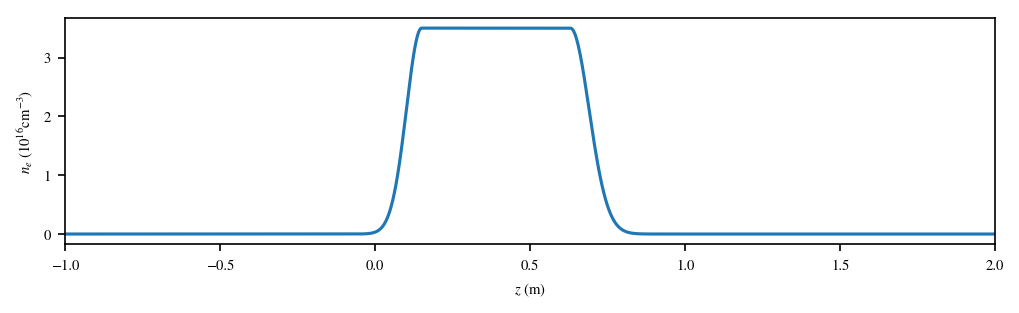

In [6]:
Nz = 2**13
Z = 2. # Length of the z grid (m), large for fft resolution
z_ne0 = 15e-2 # Start of the uniform plasma
l_ne0 = 48e-2 # Length of the uniform plasma
l_ext = 40e-2 # Hard cutoff for the exit ramp
s_ent = 4.9e-2 # sigma of the entrance ramp
s_ext = 6e-2 # sigma of the exit ramp
z, dz = np.linspace(z0, Z, Nz, retstep=True)
frac_l = np.zeros(Nz, dtype='double')

# Uniform accelerating plasma
sel_u = np.logical_and(z > z_ne0, z < z_ne0+l_ne0)
frac_l[sel_u] = 1.0

# Entrance ramp
sel_ent = np.logical_and(z >= z_ne0-l_ent, z <= z_ne0)
ramp_ent = np.exp(-(z-z_ne0)**2/(2*s_ent**2))
frac_l[sel_ent] = ramp_ent[sel_ent]

#Exit ramp
sel_ext = np.logical_and(z >= z_ne0+l_ne0, z <= z_ne0+l_ne0+l_ext)
ramp_ext = np.exp(-(z-z_ne0-l_ne0)**2/(2*s_ext**2))
frac_l[sel_ext] = ramp_ext[sel_ext]

ne_target = frac_l*ne0
# Calculate the final energy of the drive beam
drive_final['target_energy'] = drive['energy'] + simps(gradient_drive(ne_target), z)
print('Final energy of the drive beam %0.3f GeV' % drive_final['target_energy'])
witness_final['target_energy'] = witness['energy'] + simps(gradient_witness(ne_target), z)
print('Final energy of the witness beam %0.3f GeV' % witness_final['target_energy'])

xlim = [-1, 2]
plt.figure(figsize=(8, 2), dpi=150)
plt.plot(z, ne_target/1e16)
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$n_e$ ($10^{16}\mathrm{cm^{-3}}$)')
plt.xlim(xlim)
plt.show()

The drive and witness beam evolutions are found by propagating the CS parameters for each dimension. Energy change is simulated using the energy model presented above. I estimate the emittance growth by calculating the projected CS parameters. The energy spread will certainly grow in the plasma accelerator due to imperfect beam loading. In this calculation, I used an estimated energy spread from PIC sims. It should be noted that the energy spread doesn't change the saturated emittance, only the rate of emittance growth.

In [7]:
def propagate_electron_beam(N, M, ne, delta, beam):
    z_cs = z[:N]
    ne_cs = ne[:N]
    if beam == 'drive':
        init = drive
        ne0 = ne0_drive
        final = drive_final
    if beam == 'witness':
        init = witness
        ne0 = ne0_witness
        final = witness_final

    gb0A = init['gb0']*(1+delta)
    gb = np.zeros((M, N), dtype='double')
    beta_x = np.zeros((M, N), dtype='double')
    alpha_x = np.zeros((M, N), dtype='double')
    gamma_x = np.zeros((M, N), dtype='double')
    beta_y = np.zeros((M, N), dtype='double')
    alpha_y = np.zeros((M, N), dtype='double')
    gamma_y = np.zeros((M, N), dtype='double')
    for i in range(M):
        beta_x[i, :], alpha_x[i, :], gamma_x[i, :], gb[i, :] = \
        ecalc.cs_propagation(z_cs, ne_cs/1e17, init['beta0_x'], init['alpha0_x'],
                             gb0A[i], init['dgdz0'], ne0/1e17, beam)
        beta_y[i, :], alpha_y[i, :], gamma_y[i, :], gb[i, :] =  \
        ecalc.cs_propagation(z_cs, ne_cs/1e17, init['beta0_y'], init['alpha0_y'],
                             gb0A[i], init['dgdz0'], ne0/1e17, beam)

    ind = int(M/2)
    final['betas_x'] = 1/gamma_x[ind, -1]
    final['betas_y'] = 1/gamma_y[ind, -1]
    print('Final energy of the %s beam %0.3f GeV' % (beam, gb[ind, -1]*me))
    print('Exit vacuum waist of the %s beam (x, y) %0.1f, %0.1fcm' % (beam, final['betas_x']*100, 
                                                                      final['betas_x']*100))

    plt.figure(figsize=(8, 2), dpi=150)
    plt.plot(z_cs, beta_x[ind, :], label=r'$\beta_x$')
    plt.plot(z_cs, beta_y[ind, :], label=r'$\beta_y$')
    plt.title(r'Centroid energy $\beta$ function of the %s beam' % beam)
    plt.xlabel(r'$z$ (m)')
    plt.ylabel(r'$\beta$ (m)')
    plt.legend(loc=1)
    plt.ylim(0, 0.5)
    plt.twinx()
    plt.plot(z_cs, ne_cs/1e16, 'g')
    plt.ylabel(r'$n_e$ ($10^{16}\mathrm{cm^{-3}}$)')
    plt.ylim(0.0, 4)
    plt.xlim(-0.1, 1.1)
    plt.show()
    return gb, beta_x, alpha_x, gamma_x, beta_y, alpha_y, gamma_y

def emittance_growth(N, ne, beta_x, alpha_x, gamma_x, beta_y, alpha_y, gamma_y, limit, beam):
    z_cs = z[:N]
    ne_cs = ne[:N]
    if beam == 'drive':
        init = drive
        final = drive_final
    if beam == 'witness':
        init = witness
        final = witness_final
        
    sel = abs(delta) <= limit
    # Note: in the drive beam some lower energy components will decrease to 0 energy
    # We ignore these components in the calculation of the projected beta function
    betaP_x = np.nanmean(beta_x[sel, :], axis=0)
    alphaP_x = np.nanmean(alpha_x[sel, :], axis=0)
    gammaP_x = np.nanmean(gamma_x[sel, :], axis=0)
    betaP_y = np.nanmean(beta_y[sel, :], axis=0)
    alphaP_y = np.nanmean(alpha_y[sel, :], axis=0)
    gammaP_y = np.nanmean(gamma_y[sel, :], axis=0)
    eps_x = np.sqrt(betaP_x*gammaP_x-alphaP_x**2)
    eps_y = np.sqrt(betaP_y*gammaP_y-alphaP_y**2)

    final['eps_nx'] = (eps_x[-1])*init['eps_nx']
    final['eps_ny'] = (eps_y[-1])*init['eps_ny']
    print("Assuming delta=%0.3f, the beam's final emittance is (x, y) %0.1f, %0.1fum-rad" % 
          (limit, final['eps_nx']*1e6, final['eps_ny']*1e6))

    plt.figure(figsize=(8, 2), dpi=150)
    plt.plot(z_cs, eps_x, label=r'$\epsilon_{nx}$')
    plt.plot(z_cs, eps_y, label=r'$\epsilon_{ny}$')
    plt.title(r'Emittance growth of the %s beam' % beam)
    plt.xlabel(r'$z$ (m)')
    plt.ylabel(r'$\epsilon_n/\epsilon_{n0}$')
    plt.legend(loc=1)
    plt.twinx()
    plt.plot(z_cs, ne_cs/1e16, 'g')
    plt.ylabel(r'$n_e$ ($10^{16}\mathrm{cm^{-3}}$)')
    plt.ylim(0.0, 4)
    plt.xlim(-0.2, 1.1)
    plt.show()
    return eps_x, eps_y, betaP_x, betaP_y

Final energy of the drive beam 0.209 GeV
Exit vacuum waist of the drive beam (x, y) 17.5, 17.5cm


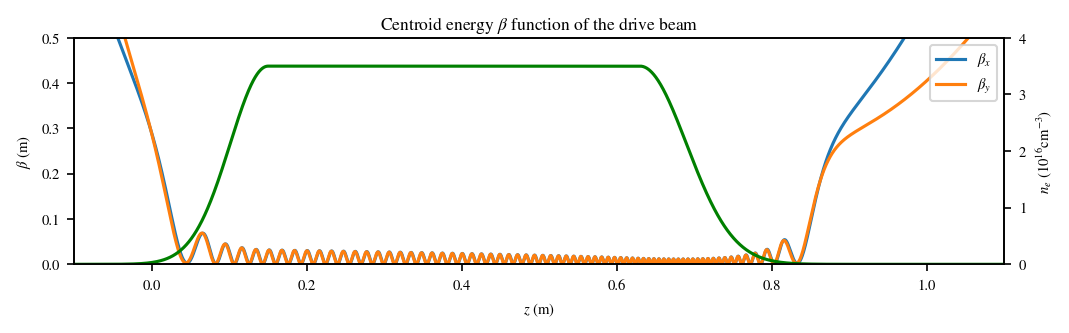

In [8]:
N = 8000 # Number of grid points in z (sets simulation length)
M = 500 # Number of chromatic components
delta = np.linspace(-0.1, 0.1, M, False)
gb, beta_x, alpha_x, gamma_x, beta_y, alpha_y, gamma_y = propagate_electron_beam(N, M, ne_target, delta, 'drive')

Assuming delta=0.080, the beam's final emittance is (x, y) 112.3, 364.6um-rad


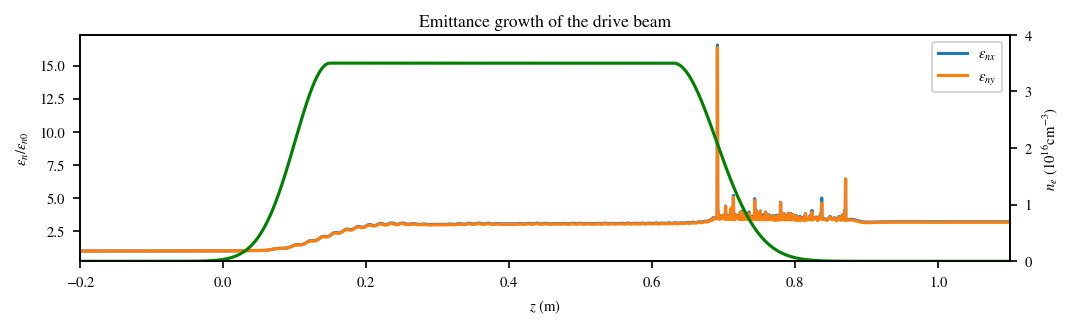

In [9]:
limit = 0.08
eps_x, eps_y, betaP_x, betaP_y = emittance_growth(N, ne_target, beta_x, alpha_x, gamma_x, beta_y, alpha_y, gamma_y, limit,
                                                  'drive')

Final energy of the witness beam 19.850 GeV
Exit vacuum waist of the witness beam (x, y) 6.5, 6.5cm


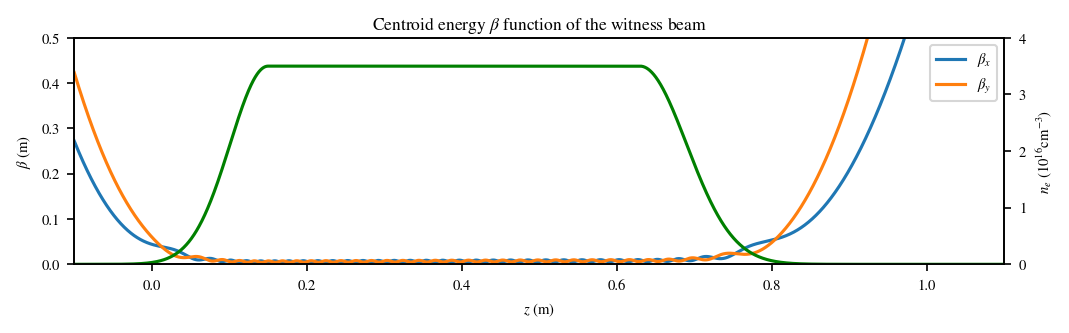

In [10]:
delta = np.linspace(-0.05, 0.05, M, False)
gb, beta_x, alpha_x, gamma_x, beta_y, alpha_y, gamma_y = propagate_electron_beam(N, M, ne_target, delta, 'witness')

Assuming delta=0.080, the beam's final emittance is (x, y) 3.9, 4.3um-rad


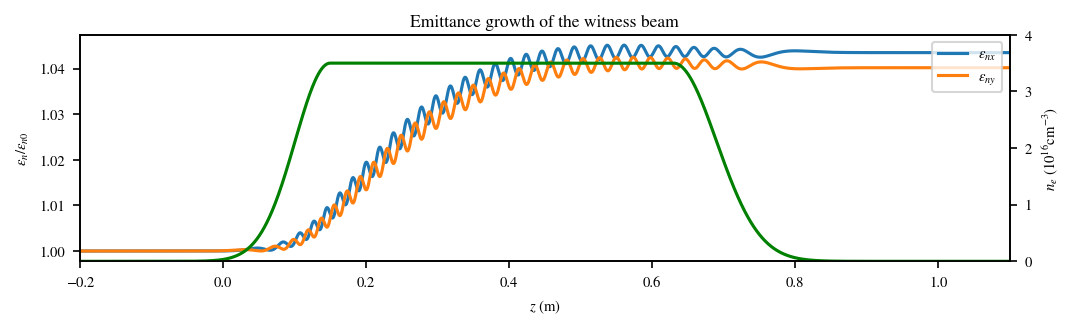

In [11]:
limit=0.04
eps_x, eps_y, betaP_x, betaP_y = emittance_growth(N, ne_target, beta_x, alpha_x, gamma_x, beta_y, alpha_y, gamma_y, 0.08,
                                                  'witness')

With the plasma design completed I use my standard optical design code to figure out the transverse intensity and phase and then propagate that through the plasma.

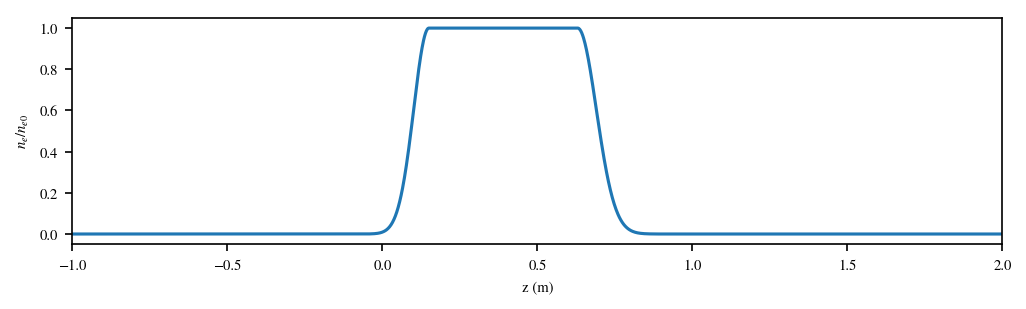

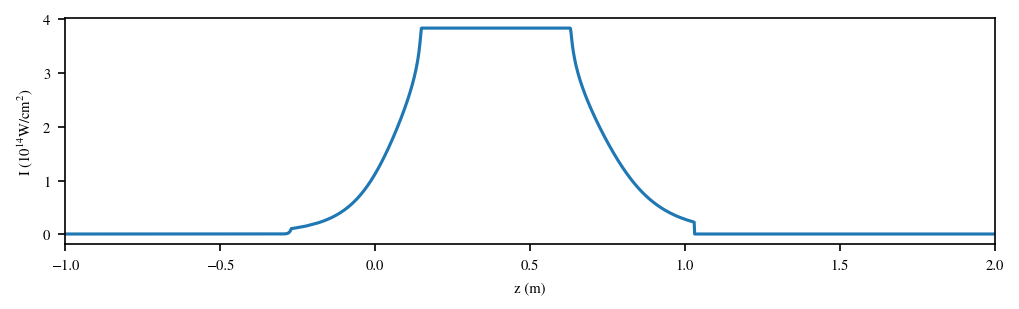

Plasma starts at -2014.47m and ends at 1.31m


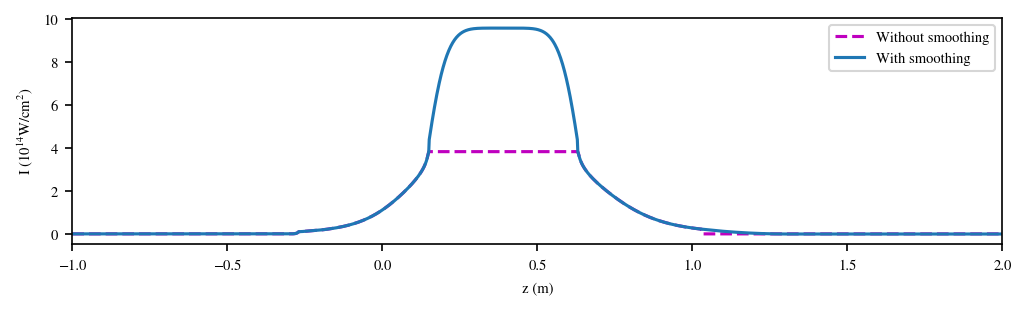

In [12]:
width = 75 # Bessel radius in um
Z_optic = 100. # Long grid for the Fourier transform
Nz_optic = 2**16 # Large number of points for the Fourier transfomr
z0_optic = -1 # Location of the optic in the beam path
xlim = [-1, 2]
tau = 70 # RMS pulse length in fs
ion = {'atom' : ionization.H2,
       'tau' : tau,
       'type' : 'gaussian'}
z_optic, I_la = profile.cutoff_gaussian_intensity(Nz_optic, Z_optic*1e6, z_ne0*1e6, l_ne0*1e6, l_ent*1e6, s_ent*1e6,
                                                  l_ext*1e6, s_ext*1e6, ion, 3, 3, path, xlim, z0_optic*1e6)

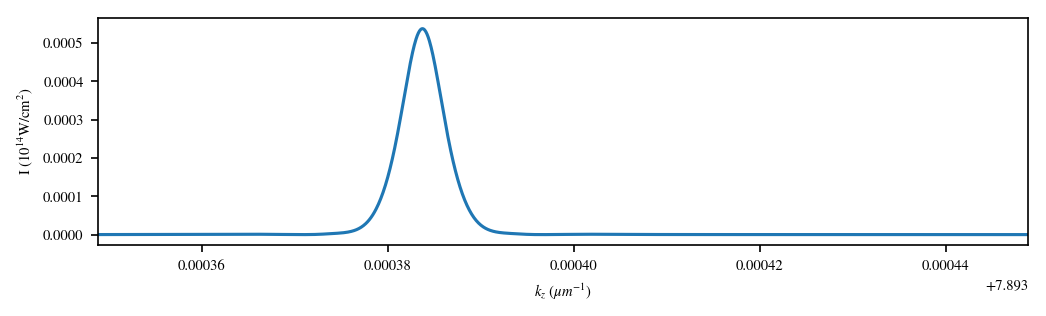

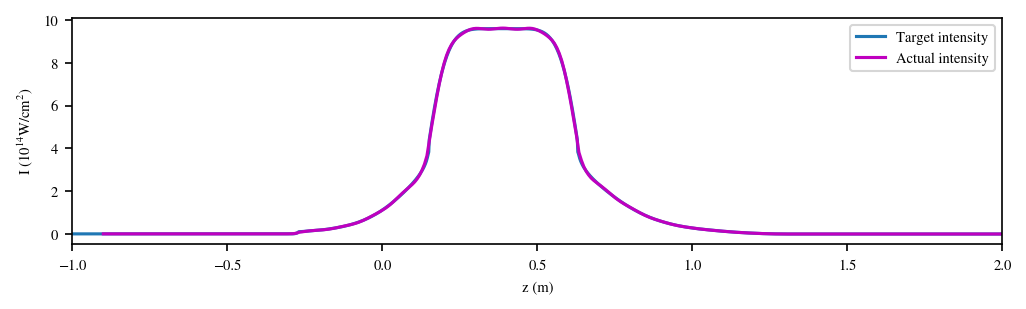

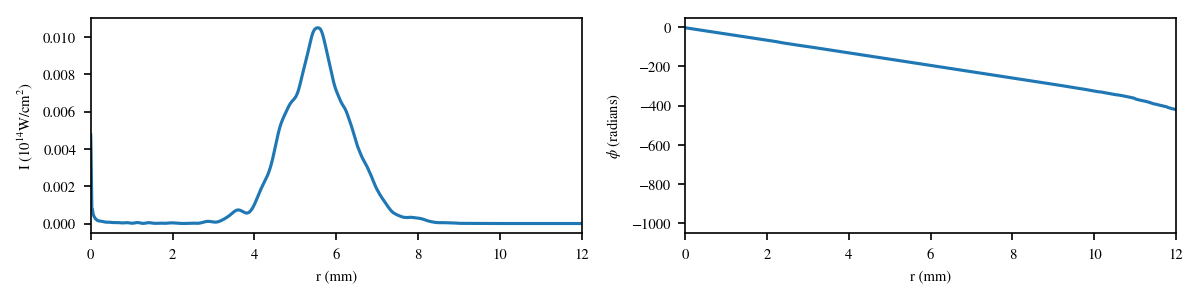

In [13]:
r, E = design.calculate_tran_field(z_optic, I_la, 20e3, width, lam, path, 10e-5, xlim, [0, 12])

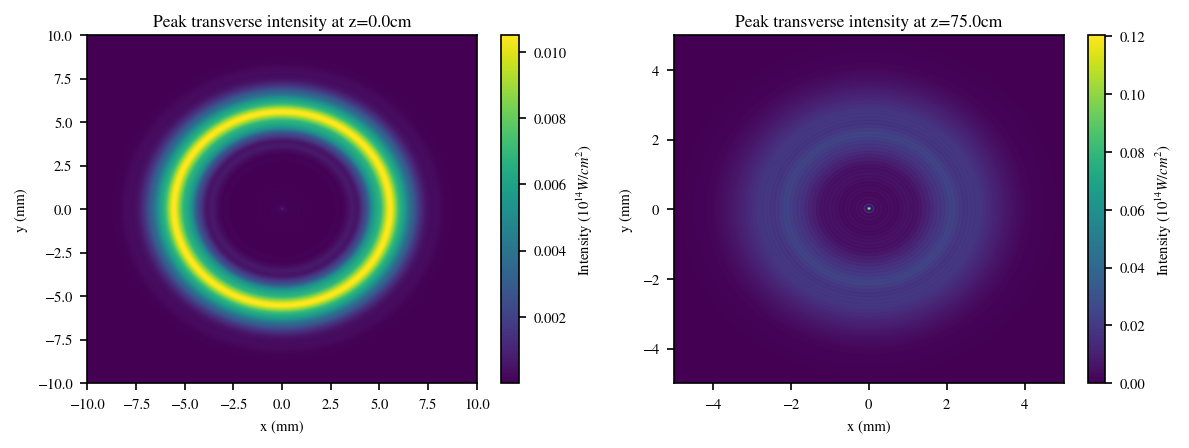

In [14]:
sim_start = -0.25
sim_length = 1.25
X = 20e3
Nx = 2**13
beam0, pulseParams = design.propagate_to_start(r, E, (sim_start-z0_optic)*1e6, X, Nx, path, lam, tau, 20, [-5, 5])

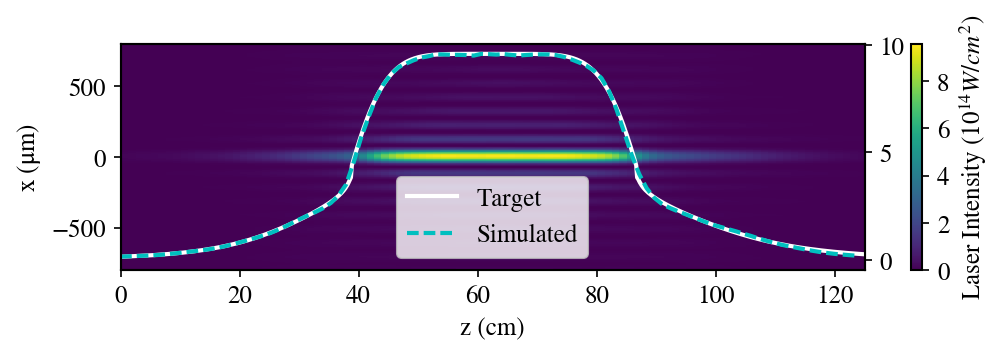

In [29]:
Nx = 2**11
Nz = 100
X = 10e3
design.domain_test(X, Nx, sim_length*1e6, Nz, beam0, pulseParams, z_optic, I_la, sim_start*1e6, [-800, 800]);

In [30]:
n = lambda z: ne0/1e17
Nx = 2**11
Nz = 500
ext = [0, sim_length/1e4*1e6, -X/2, X/2]
pulse, I, ne = design.plasma_refraction(X, Nx, sim_length*1e6, Nz, beam0, pulseParams, ionization.H2, n, sim_start*1e6, 
                                        1.0, ne0/1e17)

Initial pulse energy 45.43mJ
Final pulse energy 44.81mJ


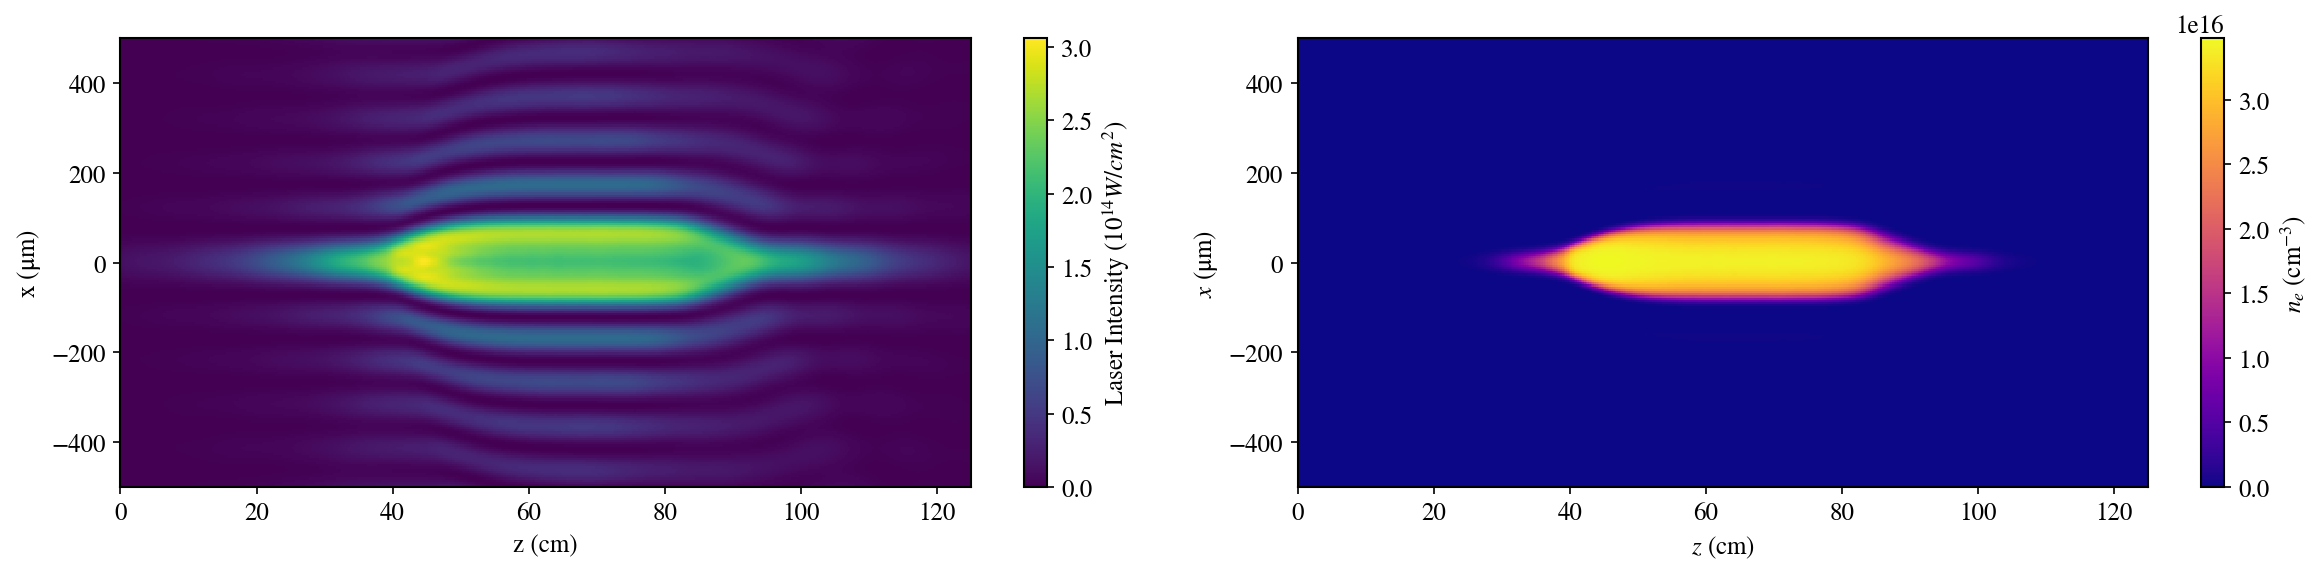

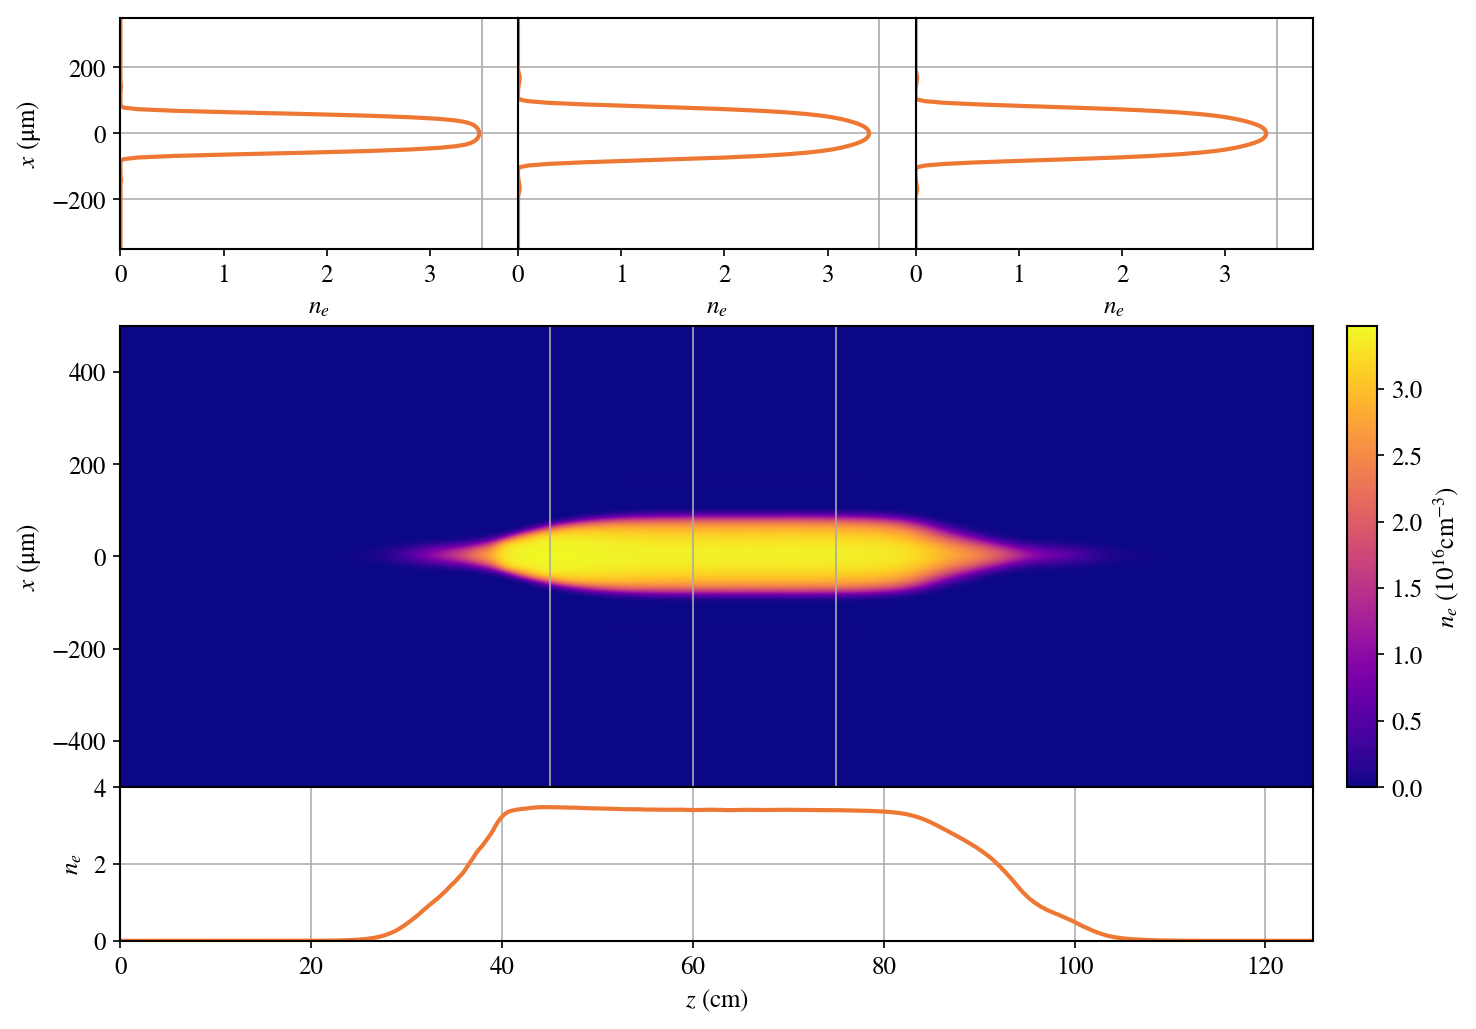

In [31]:
plt.style.use('presentation')
design.plot_laser_plasma(I, ne, ext)
design.plot_plasma_density(pulse, ne, ne0/1e17, ext, lines=[45, 60, 75])
plt.style.use('notes')

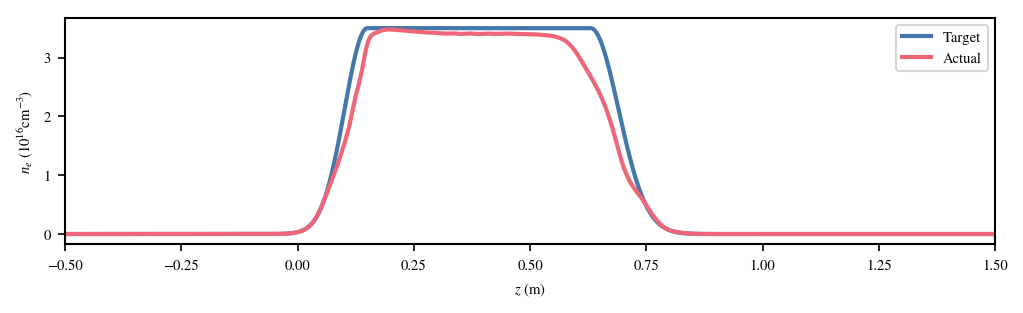

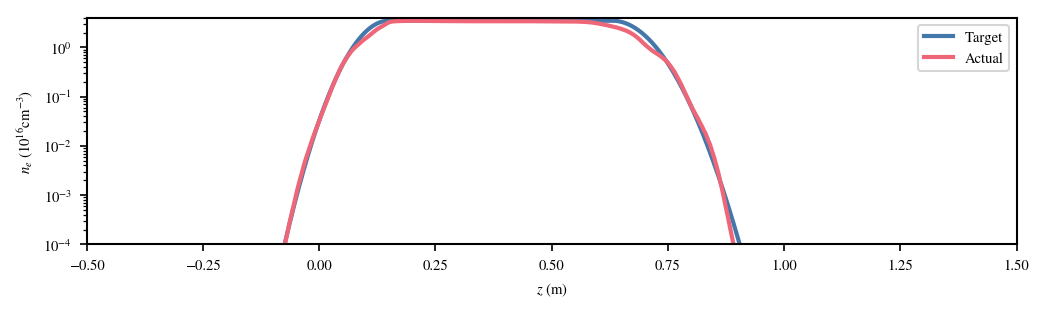

In [32]:
ne_laser = interp1d(pulse.z, ne[:, int(pulse.Nx/2)], bounds_error=False, fill_value=0.0, kind='cubic')
ne_laser = ne_laser(z*1e6-sim_start*1e6)
ne_laser[ne_laser < 0.0] = 0.0

plt.figure(figsize=(8, 2), dpi=150)
plt.plot(z, ne_target/1e16, label='Target')
plt.plot(z, ne_laser/1e16, label='Actual')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$n_e$ ($10^{16}\mathrm{cm^{-3}}$)')
plt.legend()
plt.xlim(-0.5, 1.5)
plt.show()

plt.figure(figsize=(8, 2), dpi=150)
plt.plot(z, ne_target/1e16, label='Target')
plt.plot(z, ne_laser/1e16, label='Actual')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$n_e$ ($10^{16}\mathrm{cm^{-3}}$)')
plt.legend()
plt.yscale('log')
plt.xlim(-0.5, 1.5)
plt.ylim(1e-4, 4)
plt.show()

Final energy of the drive beam 0.808 GeV
Exit vacuum waist of the drive beam (x, y) 0.8, 0.8cm


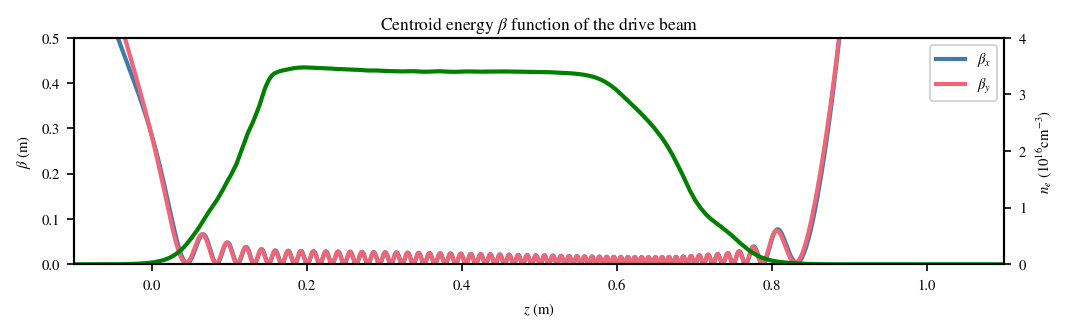

In [33]:
delta = np.linspace(-0.1, 0.1, M, False)
gb, beta_x, alpha_x, gamma_x, beta_y, alpha_y, gamma_y = propagate_electron_beam(N, M, ne_laser, delta, 'drive')

Assuming delta=0.080, the beam's final emittance is (x, y) 106.0, 344.6um-rad


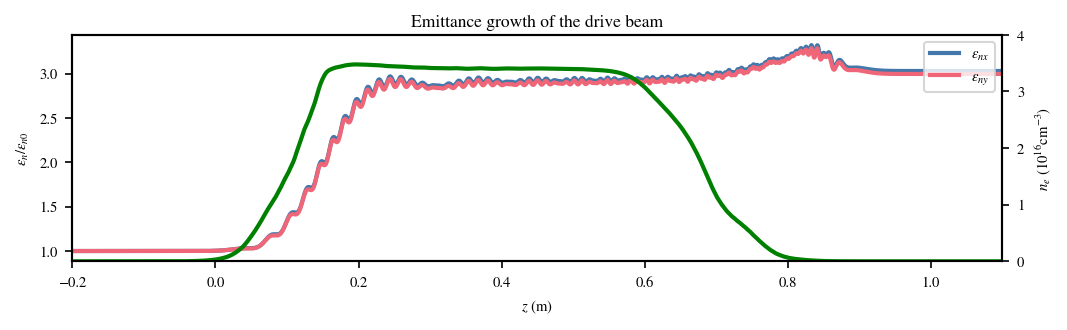

In [34]:
limit = 0.08
eps_x, eps_y, betaP_x, betaP_y = emittance_growth(N, ne_laser, beta_x, alpha_x, gamma_x, beta_y, alpha_y, gamma_y, limit,
                                                  'drive')

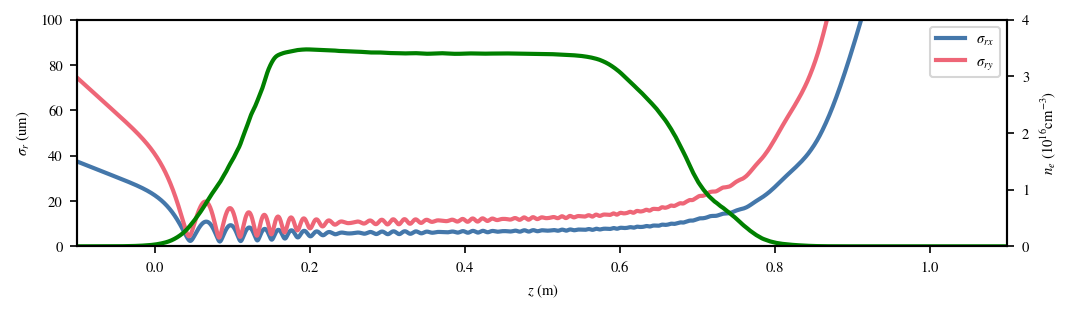

In [35]:
sigma_rx = np.sqrt(drive['eps_nx']*betaP_x/gb[int(M/2)])
sigma_ry = np.sqrt(drive['eps_ny']*betaP_y/gb[int(M/2)])
plt.figure(figsize=(8, 2), dpi=150)
plt.plot(z[:N], sigma_rx[:]*1e6, label=r'$\sigma_{rx}$')
plt.plot(z[:N], sigma_ry[:]*1e6, label=r'$\sigma_{ry}$')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$\sigma_r$ (um)')
plt.legend(loc=1)
plt.ylim(0, 100)
plt.twinx()
plt.plot(z[0:N], ne_laser[:N]/1e16, 'g')
plt.ylabel(r'$n_e$ ($10^{16}\mathrm{cm^{-3}}$)')
plt.ylim(0.0, 4)
plt.xlim(-0.1, 1.1)
plt.show()
sigma_rx = interp1d(z[:N], sigma_rx)
sigma_rx = sigma_rx(np.array(pulse.z)*1e-6+sim_start)
sigma_ry = interp1d(z[:N], sigma_ry)
sigma_ry = sigma_ry(np.array(pulse.z)*1e-6+sim_start)

In [36]:
def calc_Er(beamParams, r, xi):
    Er = np.zeros((len(r), len(xi)))
    ppK =  eb.peak_charge_dens(beamParams)
    sigma_r = beamParams['sigma_r']
    sigma_z = beamParams['sigma_z']
    sel = r != 0
    r = r[sel, None]
    Er[sel, :] = (ppK * sigma_r**2 / (eps0 * r)) * \
                (1 - np.exp(-r**2/(2*sigma_r**2))) * \
                np.exp(-(xi)**2 / (2 * sigma_z**2))
    Er[:, :] = Er[:, :] / 1e9
    return Er

In [37]:
# Multiply the transverse domain to zoom in on the beam
R_multi = 0.01
beamParams = {'sigma_z' : drive['sigma_z'],
              'charge' : drive['charge']*1e-9}
atom = ionization.H2
r = pulse.x*1e-6*R_multi
xi = np.linspace(-10*beamParams['sigma_z'], 10*beamParams['sigma_z'], 500)
t = xi*1e15/consts['speed of light in vacuum'][0]
ne_beamx = np.zeros((Nz, len(r)))
for i in range(Nz):
    beamParams['sigma_r'] = sigma_rx[i]
    #beamParams['sigma_r'] = 1e-6
    Er = calc_Er(beamParams, r, xi)
    rate_x_He = adk.rate_static(atom['EI'], abs(Er), atom['Z'], atom['l'], atom['m'])
    ne_beamx[i, :] = 1-np.exp(-simps(rate_x_He*1e15, t))

2.58367958762e-05


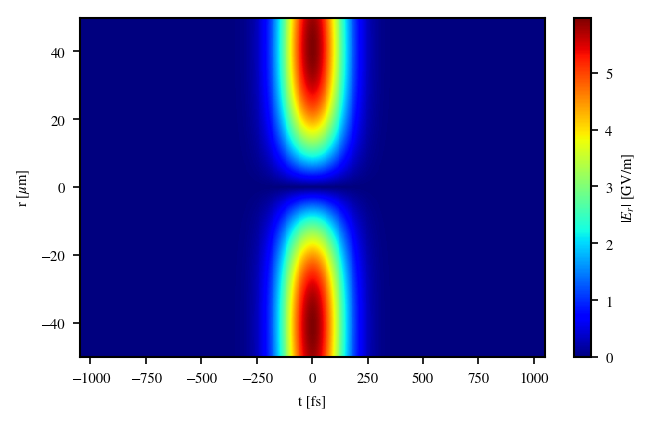

In [38]:
i = 93
beamParams['sigma_r'] = sigma_rx[i]
print(sigma_rx[i])
Er = calc_Er(beamParams, r, xi)

ext2 = [min(t), max(t), min(r)*1e6, max(r)*1e6]
fig1 = plt.figure(figsize = (5,3), dpi = 150)
ax1 = fig1.gca()
img1 = ax1.imshow(np.flipud(abs(Er)), cmap = 'jet',aspect = 'auto', \
    extent = ext2)
cbar1 = plt.colorbar(mappable = img1, ax = ax1)
cbar1.set_label('$|E_r|$ [GV/m]')

ax1.set_xlabel('t [fs]');
ax1.set_ylabel('r [$\mu$m]');
plt.show()

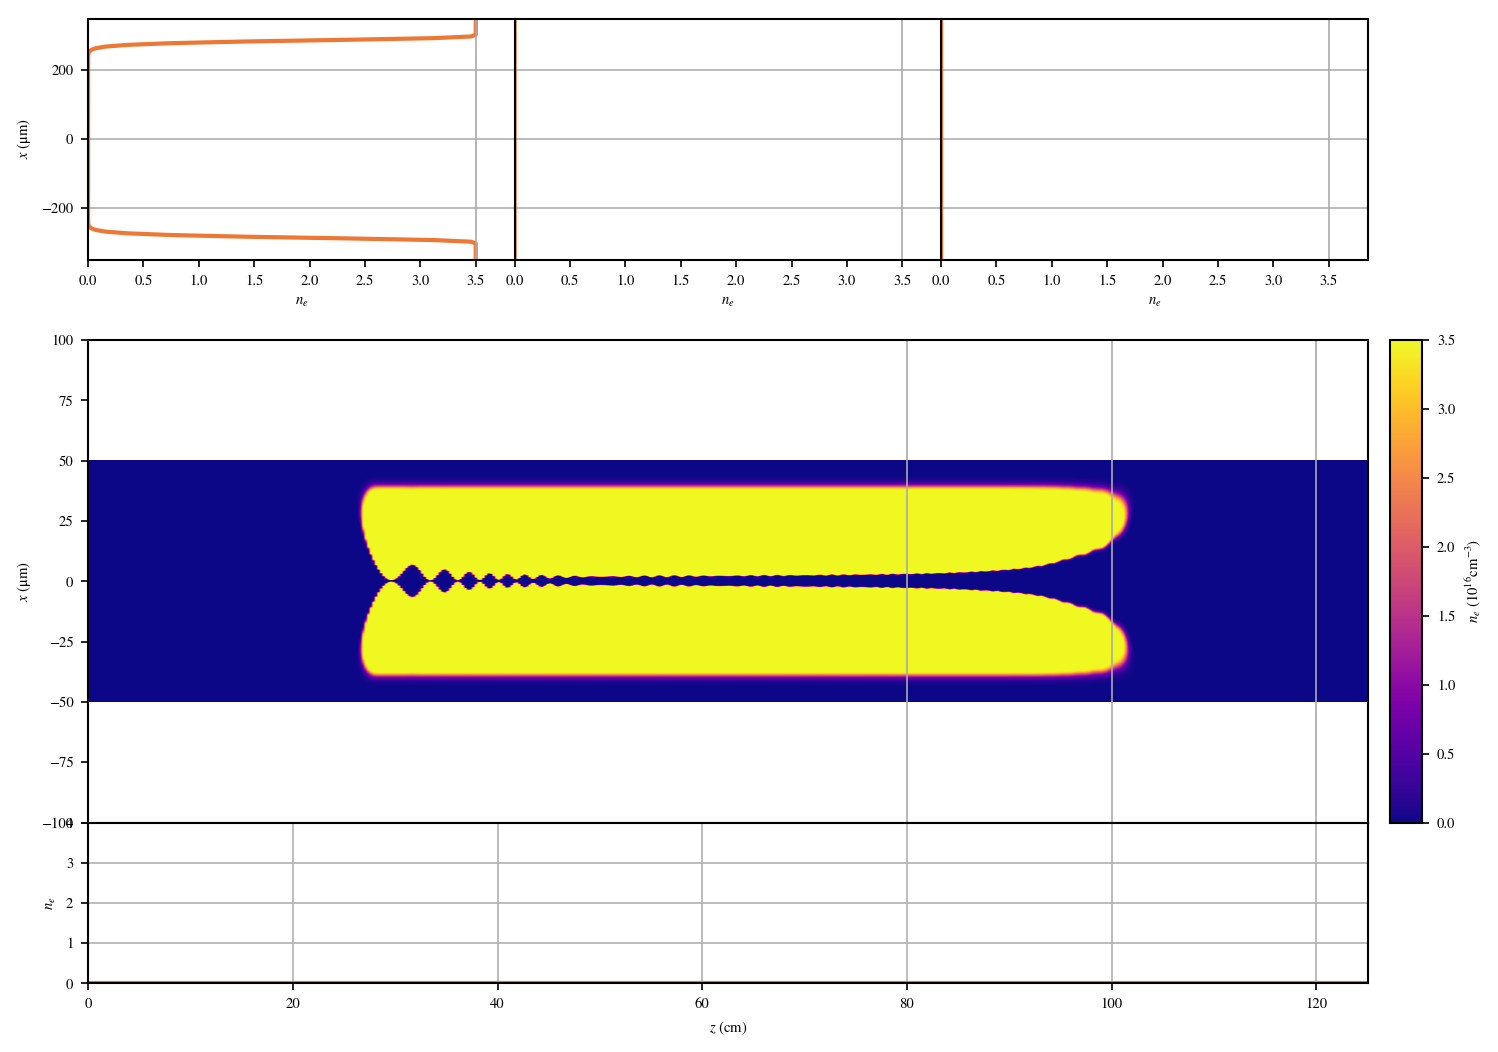

In [39]:
ext3 = np.copy(ext)
ext3[2] = ext[2]*R_multi
ext3[3] = ext[3]*R_multi
design.plot_plasma_density(pulse, ne_beamx*ne0, ne0/1e17, ext3, lines=[80, 100, 120], ylim=[-100, 100])

Final energy of the witness beam 17.941 GeV
Exit vacuum waist of the witness beam (x, y) 4.6, 4.6cm


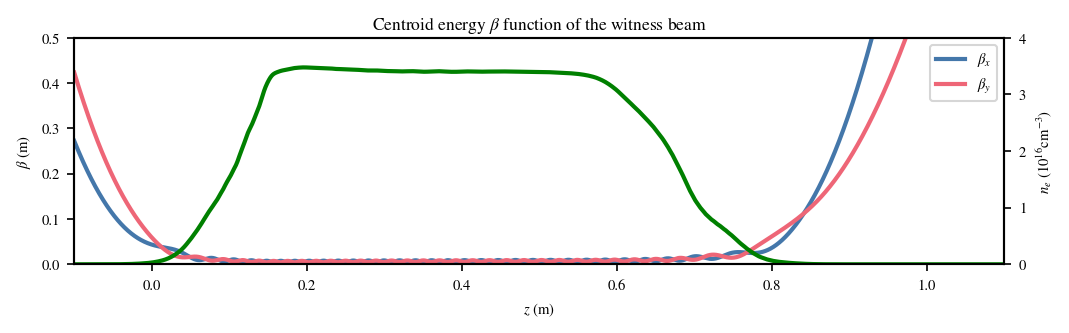

In [40]:
delta = np.linspace(-0.05, 0.05, M, False)
gb, beta_x, alpha_x, gamma_x, beta_y, alpha_y, gamma_y = propagate_electron_beam(N, M, ne_laser, delta, 'witness')

Assuming delta=0.080, the beam's final emittance is (x, y) 3.9, 4.3um-rad


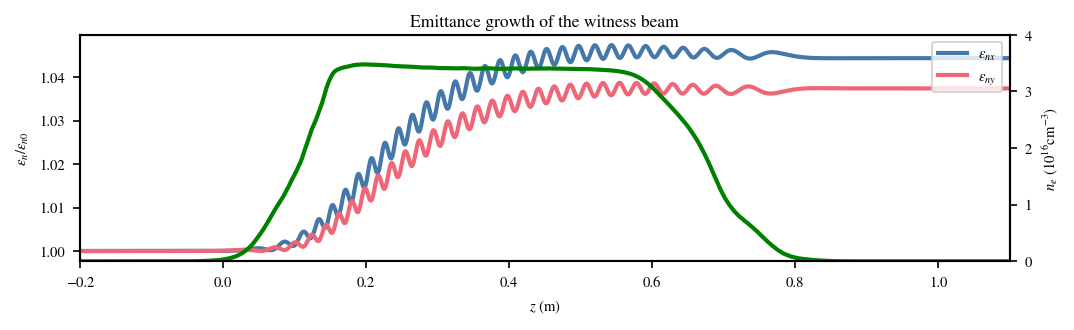

In [41]:
limit=0.04
eps_x, eps_y, betaP_x, betaP_y = emittance_growth(N, ne_laser, beta_x, alpha_x, gamma_x, beta_y, alpha_y, gamma_y, 0.08,
                                                  'witness')